## Sales Prediction Model

## Contents

## Introduction

## Imports

In [1]:
# Basic Packages and Data Manipulation
import pandas as pd
import numpy as np
from pandasql import sqldf
import pandasql as psql
import random

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Machine Learning: Preprocessing, Models, and Evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, make_scorer, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, recall_score, r2_score
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance
from sklearn.pipeline import make_pipeline 
import shap
from sklearn.model_selection import GridSearchCV

## Load

In [2]:
data = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\exports_2\data.csv")

## Set Options

In [23]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# Load JS visualization code to notebook 
shap.initjs()

## Baseline XG Boost Model & Plots of the Residuals

In [4]:
data.head()

,household_key,week_no,total_sales_value,redemption_rate,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,marital_status_Married,marital_status_Single,marital_status_Unknown,income_desc_100-124K,income_desc_125-149K,income_desc_15-24K,income_desc_150-174K,income_desc_175-199K,income_desc_200-249K,income_desc_25-34K,income_desc_250K+,income_desc_35-49K,income_desc_50-74K,income_desc_75-99K,income_desc_Under 15K,homeowner_desc_Homeowner,homeowner_desc_Probable Owner,homeowner_desc_Probable Renter,homeowner_desc_Renter,homeowner_desc_Unknown,hh_comp_desc_1 Adult Kids,hh_comp_desc_2 Adults Kids,hh_comp_desc_2 Adults No Kids,hh_comp_desc_Single Female,hh_comp_desc_Single Male,hh_comp_desc_Unknown,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown
0,1,33,123.86,0.755287,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True
1,1,34,42.80,0.755287,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True
2,1,36,80.45,0.755287,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True
3,1,38,72.82,0.755287,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True
4,1,40,113.07,0.755287,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True


<b> Baseline Model: XG Boost </b>

In [5]:
# Drop the columns I don't want here, including the target
X = data.drop(columns= ['household_key', 'week_no', 'total_sales_value'], axis=1)  
y = data['total_sales_value']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [6]:
base_model = XGBRegressor()

base_model.fit(X_train, y_train)

y_pred = base_model.predict(X_test)

rmse_base = np.sqrt(mean_squared_error(y_test, y_pred))
mae_base = mean_absolute_error(y_test, y_pred)

rmse_base, mae_base

(59.052343961256156, 42.45571076399534)

<b> Plot residuals  & IQR for different multipliers</b>

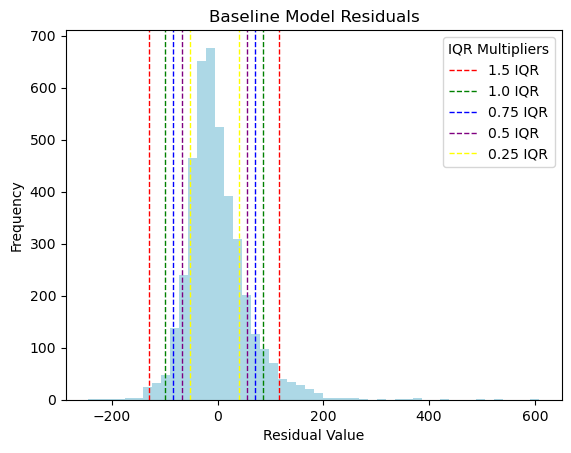

In [7]:

# Baseline residuals in our original model
residuals_base = y_test - y_pred

# Calculate Q1, Q3, and IQR
Q1 = np.percentile(residuals_base, 25)
Q3 = np.percentile(residuals_base, 75)
IQR = Q3 - Q1

# Define IQR multipliers and their associated colors
iqr_multipliers = [1.5, 1.0, 0.75, 0.5, 0.25]
colors = ['red', 'green', 'blue', 'purple', 'yellow']

# Plot histogram
plt.hist(residuals_base, bins=50, color='lightblue') 
plt.title('Baseline Model Residuals')
plt.xlabel("Residual Value")
plt.ylabel("Frequency")

# To avoid duplicate legend entries
added_multipliers = set()

# Add vertical lines based on IQR multipliers
for multiplier, color in zip(iqr_multipliers, colors):
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    label = None
    if multiplier not in added_multipliers:
        label = f'{multiplier} IQR'
        added_multipliers.add(multiplier)
        
    plt.axvline(x=lower_bound, color=color, linestyle='--', linewidth=1, label=label)
    plt.axvline(x=upper_bound, color=color, linestyle='--', linewidth=1)

plt.legend(title='IQR Multipliers')
plt.show()


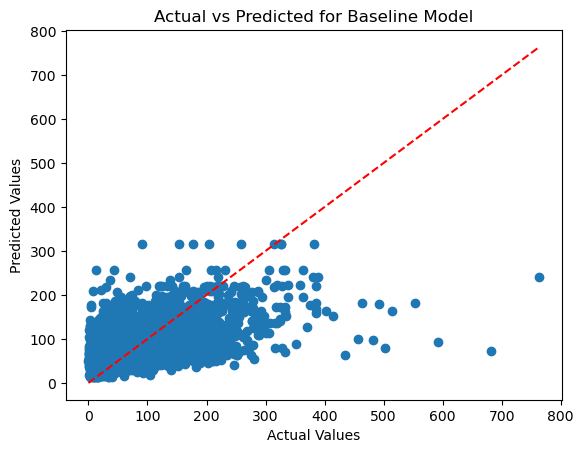

In [8]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('Actual vs Predicted for Baseline Model')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


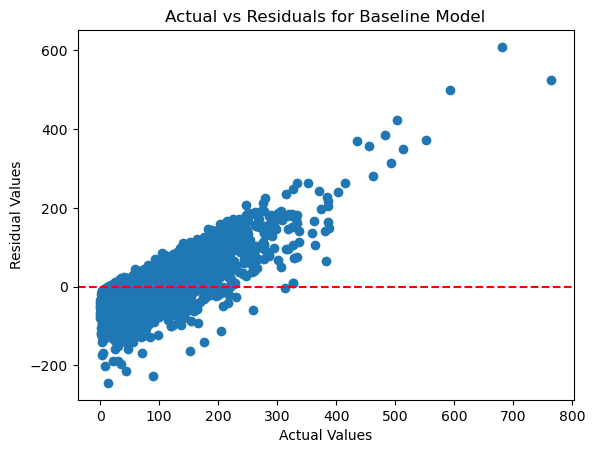

In [9]:
plt.scatter(y_test, residuals_base)
plt.axhline(y=0, color='r', linestyle='--') 
plt.title('Actual vs Residuals for Baseline Model')
plt.xlabel('Actual Values')
plt.ylabel('Residual Values')
plt.show()

The actual vs residuals model is especially interesting - I'd like to see if things improve if I remove outliers using IQR.

<b> Make some new dataframes with different IQR multipiers</b>

In [10]:
# Define rangeS
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1

#IQR = 1
lower_bound_1 = Q1 - 1.0 * IQR 
upper_bound_1= Q3 + 1.0 * IQR

#IQR = 1.5
lower_bound_15 = Q1 - 1.5 * IQR 
upper_bound_15= Q3 + 1.5 * IQR

#IQR = 0.75
lower_bound_075 = Q1 - 0.75 * IQR 
upper_bound_075= Q3 + 0.75 * IQR

#IQR = 0.5
lower_bound_05 = Q1 - 0.5 * IQR 
upper_bound_05= Q3 + 0.5 * IQR

#IQR = 0.25
lower_bound_25 = Q1 - 0.25 * IQR 
upper_bound_25= Q3 + 0.25 * IQR


In [11]:
IQR_15_data = data[(data['total_sales_value'] >= lower_bound_15) & (data['total_sales_value'] <= upper_bound_15)]
IQR_1_data = data[(data['total_sales_value'] >= lower_bound_1) & (data['total_sales_value'] <= upper_bound_1)]
IQR_075_data = data[(data['total_sales_value'] >= lower_bound_075) & (data['total_sales_value'] <= upper_bound_075)]
IQR_05_data = data[(data['total_sales_value'] >= lower_bound_05) & (data['total_sales_value'] <= upper_bound_05)]
IQR_025_data = data[(data['total_sales_value'] >= lower_bound_25) & (data['total_sales_value'] <= upper_bound_25)]

<b> Make a function that runs the model, adds to the above plots, and stores the error metrics </b>

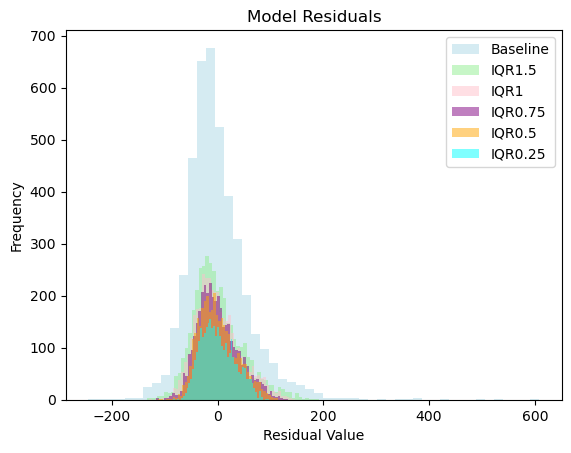

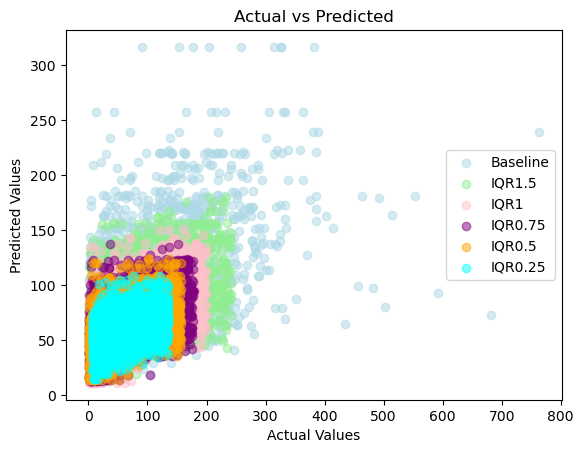

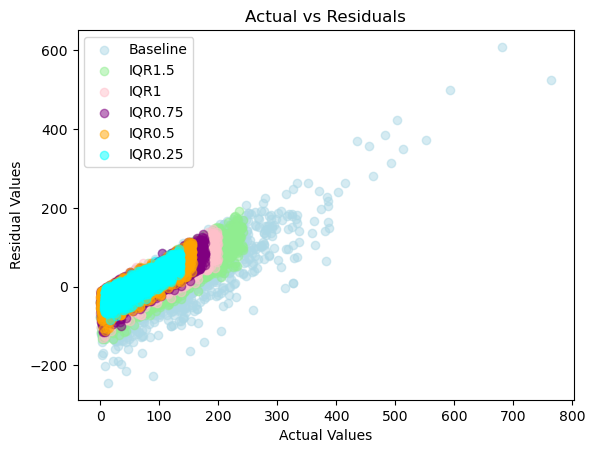

    Variant       RMSE        MAE
0  Baseline  59.052344  42.455711
1    IQR1.5  47.241592  36.818786
2      IQR1  42.466066  33.635008
3   IQR0.75  38.376772  30.602358
4    IQR0.5  36.233430  29.286820
5   IQR0.25  31.650459  26.069642


In [12]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

# store metrics here
metrics = pd.DataFrame(columns=['Variant', 'RMSE', 'MAE'])

# Pre-defined colors
colors = ['lightblue', 'lightgreen', 'pink', 'purple', 'orange', 'cyan', 'yellow']

def run_model_variant(data, variant_name, cols_to_drop, target_col, test_size=0.1, random_state=42, color_idx=0):
    global metrics
    
    # Drop specified columns and define target
    X = data.drop(columns=cols_to_drop, axis=1)
    y = data[target_col]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Train model
    model = XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate residuals
    residuals = y_test - y_pred
    
    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Store the metrics in the DataFrame
    metrics = pd.concat([metrics, pd.DataFrame([{'Variant': variant_name, 'RMSE': rmse, 'MAE': mae}])], ignore_index=True)

    # Generate a distinct color from the list
    color = colors[color_idx % len(colors)]
    
    # Plotting
    ax1.hist(residuals, bins=50, alpha=0.5, label=f"{variant_name}", color=color)
    ax1.set_title('Model Residuals')
    ax1.set_xlabel("Residual Value")
    ax1.set_ylabel("Frequency")
    ax1.legend()
    
    ax2.scatter(y_test, y_pred, alpha=0.5, label=f"{variant_name}", color=color)
    ax2.set_title('Actual vs Predicted')
    ax2.set_xlabel('Actual Values')
    ax2.set_ylabel('Predicted Values')
    ax2.legend()
    
    ax3.scatter(y_test, residuals, alpha=0.5, label=f"{variant_name}", color=color)
    ax3.set_title('Actual vs Residuals')
    ax3.set_xlabel('Actual Values')
    ax3.set_ylabel('Residual Values')
    ax3.legend()

    return rmse, mae

cols_to_drop = ['household_key', 'week_no', 'total_sales_value']
target_col = 'total_sales_value'

# Initialize color index
color_idx = 0

# Running the models
rmse_base, mae_base = run_model_variant(data, "Baseline", cols_to_drop, target_col, color_idx=color_idx)
color_idx += 1  

rmse_IQR15, mae_IQR15 = run_model_variant(IQR_15_data, "IQR1.5", cols_to_drop, target_col, color_idx=color_idx)
color_idx += 1  

rmse_IQR1, mae_IQR1 = run_model_variant(IQR_1_data, "IQR1", cols_to_drop, target_col, color_idx=color_idx)
color_idx += 1  

rmse_IQR075, mae_IQR075 = run_model_variant(IQR_075_data, "IQR0.75", cols_to_drop, target_col, color_idx=color_idx)
color_idx += 1  

rmse_IQR05, mae_IQR05 = run_model_variant(IQR_05_data, "IQR0.5", cols_to_drop, target_col, color_idx=color_idx)
color_idx += 1

rmse_IQR025, mae_IQR025 = run_model_variant(IQR_025_data, "IQR0.25", cols_to_drop, target_col, color_idx=color_idx)
color_idx += 1

plt.show()

print(metrics)

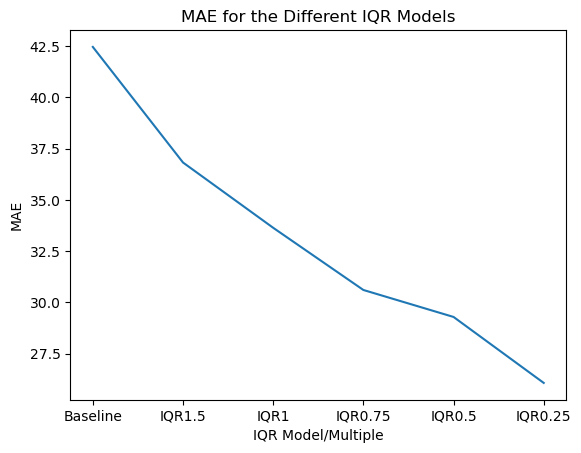

In [13]:
plt.plot(metrics.Variant,metrics.MAE)
plt.title('MAE for the Different IQR Models')
plt.xlabel('IQR Model/Multiple')
plt.ylabel('MAE')
plt.show()

<b> I am going to pick the IQR with a multiplier of 0.25 </b>


As expected, the smaller we make the IQR band, the better our model gets. 

In [14]:
print('Mean Sales Value: ',IQR_025_data['total_sales_value'].mean())

Mean Sales Value:  57.89893249852025


<b> Define a function to run and evaluate each model variant</b>

In [33]:
# Already defined cols_to_drop and target_col earlier

# Create a dataframe to store metrics in
model_metrics = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'R2'])

def run_and_evaluate_model(data, model_name, cols_to_drop, target_col, hyper_params=None):
    global model_metrics
    
    X = data.drop(columns=cols_to_drop, axis=1)
    y = data[target_col]
    
    # Training
    model = xgb.XGBRegressor(**hyper_params) if hyper_params else xgb.XGBRegressor()
    model.fit(X, y)
    
    model.save_model(f"{model_name}.model")
    
    # Predict
    y_pred = model.predict(X)
    
    # Calculate Metrics
    MAE = round(mean_absolute_error(y, y_pred), 2)
    RMSE = round(mean_squared_error(y, y_pred, squared=False), 2)
    R2 = round(r2_score(y, y_pred), 2)
    
    # Append to DataFrame
    new_metrics = pd.DataFrame({'Model': [model_name], 'MAE': [MAE], 'RMSE': [RMSE], 'R2': [R2]})
    model_metrics = pd.concat([model_metrics, new_metrics], ignore_index=True)
    
    return model


In [37]:
IQR_025 = run_and_evaluate_model(IQR_025_data, 'IQR_025', cols_to_drop, target_col)

In [35]:
model_metrics

,Model,MAE,RMSE,R2
0,IQR_025,25.61,31.15,0.21


### Hyper parameter tuning

In [18]:
X = IQR_025_data.drop(columns=['household_key', 'week_no', 'total_sales_value'], axis=1)
y = IQR_025_data['total_sales_value']

# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 4, 5, 8],
    'n_estimators': [50, 100, 150, 200],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')

# Fit 
grid_search.fit(X, y)

# Get best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Use the best model to make predictions
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7}
Best Score: -29.07280052387344


In [20]:
# re-run model with these parameters

hyper_params = {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7}
run_and_evaluate_model(IQR_025_data, 'IQR_025_tuned', cols_to_drop, target_col, hyper_params)

model_metrics

,Model,MAE,RMSE,R2
0,IQR_025,25.61,31.15,0.21
1,IQR_025_tuned,27.96,34.25,0.05


<b> My original model is better </b>

### SHAP ANALYSIS

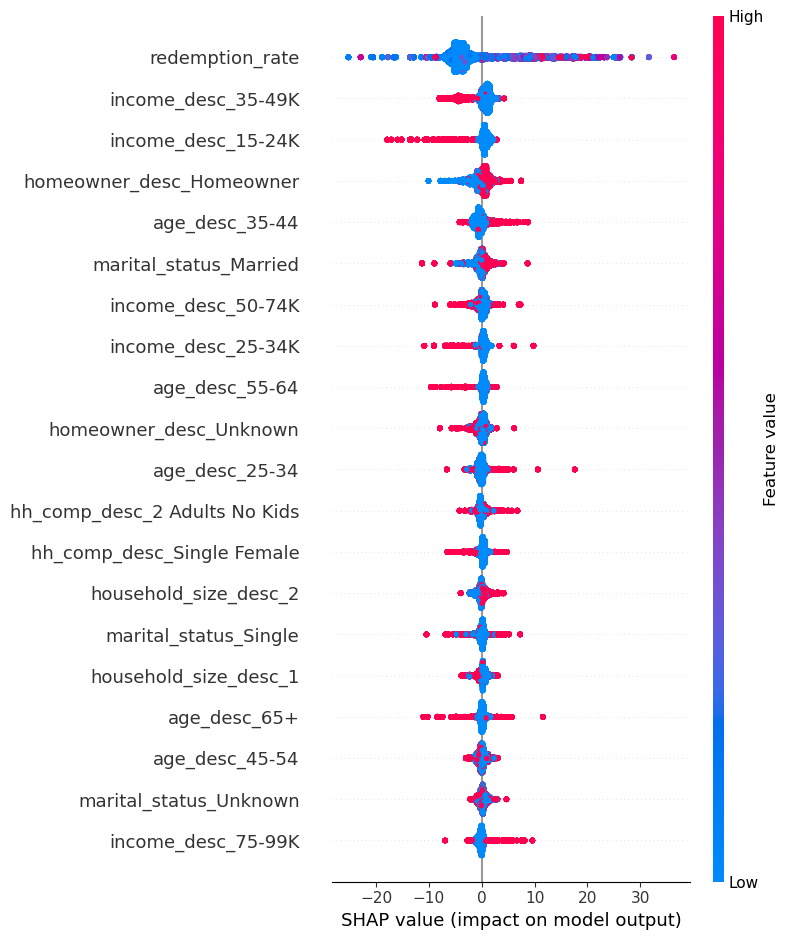

In [38]:
explainer = shap.Explainer(IQR_025)
shap_values = explainer(X)
shap.summary_plot(shap_values, X)
